In [1]:
### Run this cell to import the packages you will need to unpack the dataset
# File manipulation and IO (input/output)
import os

# Import numerical and dataframe handling
import numpy as np

# Data preprocessing
from PIL import Image
from skimage.color import rgb2lab
from sklearn.model_selection import train_test_split

# Model scoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import completeness_score
from sklearn import metrics

# Import standard machine learning machinery
import tensorflow as tf


# Import plotting functionality
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import matplotlib



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Set plotting preferences
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

In [3]:
# Load the images
# Path to the directory containing PNG images
subdirectories = []
for entry in os.listdir('/kaggle/input/multiple-sclerosis/Multiple Sclerosis'):
    full_path = os.path.join('/kaggle/input/multiple-sclerosis/Multiple Sclerosis', entry)
    if os.path.isdir(full_path):
          subdirectories.append(full_path)

# Initialize lists to store images and corresponding labels
images = []
labels = []

# Load images and labels
for dataset_dir in subdirectories:
  for image_name in os.listdir(dataset_dir):
    if image_name.lower().endswith('.png'):
        image_path = os.path.join(dataset_dir, image_name)
        # Open the image using Pillow
        image = Image.open(image_path)
        # Optional: Resize the image to a consistent size (e.g., 128x128)
        image = image.resize((128, 128))
        # Convert the image to grayscale (L mode)
        image = image.convert("L")
        # Convert the image to a numpy array
        image_array = np.array(image)
        # Normalize the pixel values (divide by 255)
        image_array = image_array / 255.0
        # Append the image and label to the lists
        images.append(image_array)
        # Add the class label based on your dataset's structure
        # For example, if 'MS-A' is a class, you can extract the label from the filename.
        label = image_name.split('-')[0]  # Extracts 'MS' from 'MS-A (218).png'
        labels.append(label)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)
print(labels)

# Convert string labels to integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}

labels = np.array([label_mapping[label] for label in labels], dtype=np.int32)

# Print the shape of the data for verification
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

['MS' 'MS' 'MS' ... 'C' 'C' 'C']
Images shape: (3427, 128, 128)
Labels shape: (3427,)


In [4]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shape of the data for verification
print("Training Images shape:", X_train.shape)
print("Training Labels shape:", y_train.shape)
print("Validation Images shape:", X_val.shape)
print("Validation Labels shape:", y_val.shape)
print("Test Images shape:", X_test.shape)
print("Test Labels shape:", y_test.shape)


Training Images shape: (2192, 128, 128)
Training Labels shape: (2192,)
Validation Images shape: (549, 128, 128)
Validation Labels shape: (549,)
Test Images shape: (686, 128, 128)
Test Labels shape: (686,)


In [5]:
# Add 3rd channel to convert to RGB
X_train = np.repeat(X_train[:, :, :, np.newaxis], 3, axis=3)
X_val = np.repeat(X_val[:, :, :, np.newaxis], 3, axis=3)
X_test = np.repeat(X_test[:, :, :, np.newaxis], 3, axis=3)
print(X_train.shape)


(2192, 128, 128, 3)


In [6]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(labels))).astype(np.float32)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(np.unique(labels))).astype(np.float32)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(labels))).astype(np.float32)

print(y_test.shape)

(686, 2)


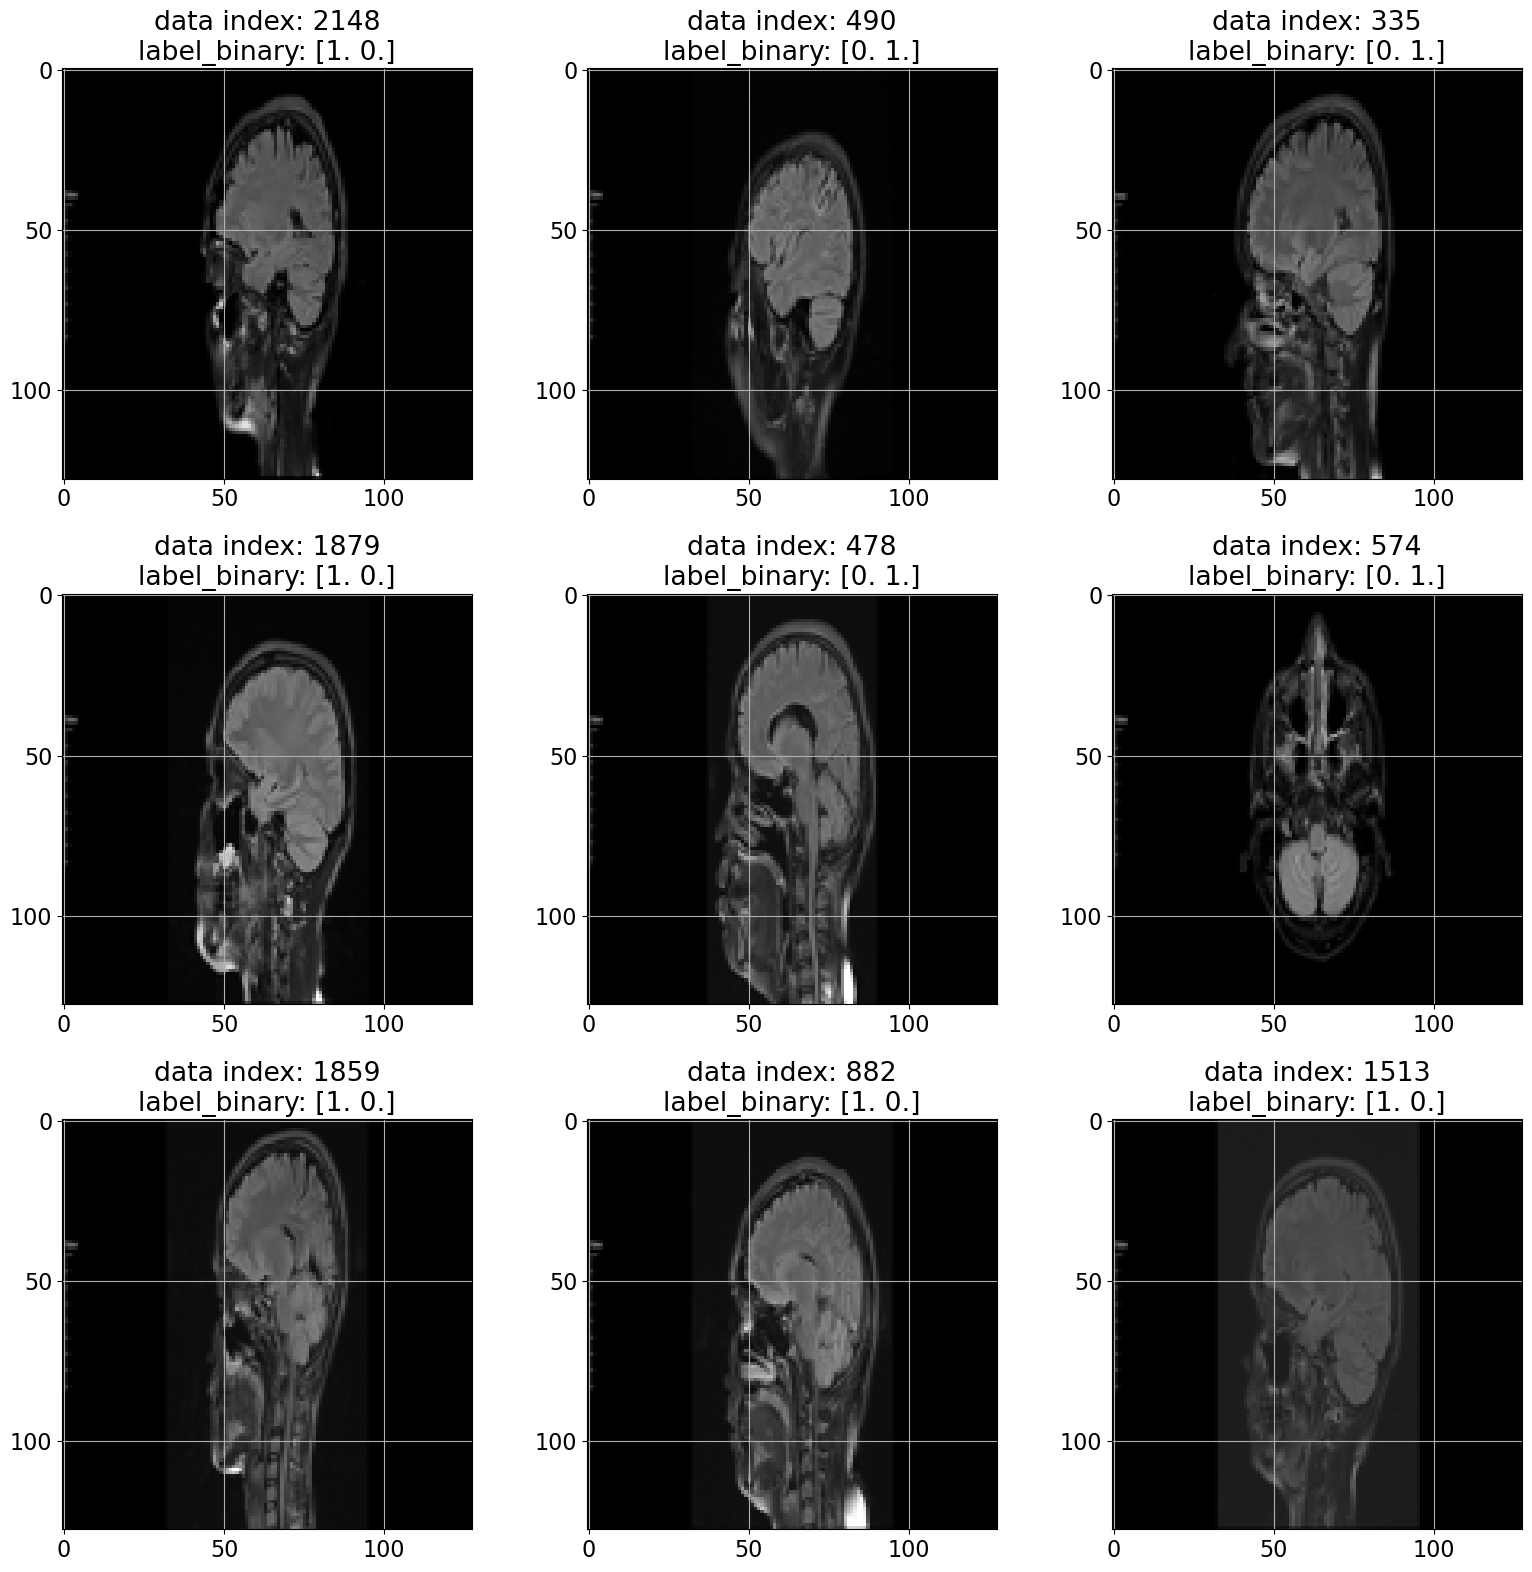

In [7]:
### Visualize Images in Training Set

fig = plt.figure(figsize = (16,16))

for i in range(9): # change these numbers to explore the training dataset further
  imgInd = np.random.randint(0, len(X_train))
  ax = plt.gcf().add_subplot(3, 3, i+1)
  ax.imshow(X_train[imgInd], cmap='gray', vmin=0, vmax=255)
  ax.set_title("data index: " + str(imgInd) + "\nlabel_binary: " +
            str(y_train[imgInd]))

  #set major tick marks every 50 pixels
  ax.xaxis.set_major_locator(MultipleLocator(50))
  ax.yaxis.set_major_locator(MultipleLocator(50))

  #turn on grid lines
  ax.grid(True)

fig.tight_layout()

In [8]:
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [9]:
# Define the CNN architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, (7, 7), activation='relu', padding = 'same', input_shape = X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0

In [10]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)
model.fit(X_train, y_train, epochs=30, batch_size=16, callbacks=[early_stopping,lr_scheduler], validation_data=(X_val, y_val))


Epoch 1/30


2024-02-17 20:42:23.515423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


137/137 [==============================] - 13s 23ms/step - loss: 0.5450 - accuracy: 0.7185 - val_loss: 0.3991 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 2/30
137/137 [==============================] - 3s 18ms/step - loss: 0.3920 - accuracy: 0.8207 - val_loss: 0.3661 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 3/30
137/137 [==============================] - 3s 18ms/step - loss: 0.2930 - accuracy: 0.8745 - val_loss: 0.3152 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 4/30
137/137 [==============================] - 3s 18ms/step - loss: 0.2264 - accuracy: 0.9033 - val_loss: 0.2635 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 5/30
137/137 [==============================] - 3s 18ms/step - loss: 0.1748 - accuracy: 0.9284 - val_loss: 0.3098 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 6/30
137/137 [==============================] - 3s 18ms/step - loss: 0.1433 - accuracy: 0.9462 - val_loss: 0.2571 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 7/30
137/137 [==============================] - 3s 18ms/step - loss:

In [11]:
# Define the CNN architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, GlobalAveragePooling2D

# Load VGG19 model without top layers (include_top=False) and specify the input shape
model2 = Sequential()
base_model = tf.keras.applications.VGG19(input_shape=X_train.shape[1:],include_top=False, weights='imagenet')
base_model.trainable = False
model2.add(base_model)
model2.add(BatchNormalization())
model2.add(Conv2D(32, (7, 7), activation='relu', padding = 'same', input_shape = X_train.shape[1:]))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.5))
model2.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          802848    
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 32)         128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                   

In [12]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)
model2.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[early_stopping,lr_scheduler], validation_data=(X_val, y_val))


Epoch 1/50


2024-02-17 20:43:06.628016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


137/137 [==============================] - 11s 50ms/step - loss: 0.6436 - accuracy: 0.6446 - val_loss: 0.5465 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 2/50
137/137 [==============================] - 5s 40ms/step - loss: 0.5138 - accuracy: 0.7386 - val_loss: 0.4820 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 3/50
137/137 [==============================] - 5s 40ms/step - loss: 0.4421 - accuracy: 0.7929 - val_loss: 0.3708 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 4/50
137/137 [==============================] - 5s 40ms/step - loss: 0.3999 - accuracy: 0.8203 - val_loss: 0.3437 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 5/50
137/137 [==============================] - 5s 40ms/step - loss: 0.3681 - accuracy: 0.8435 - val_loss: 0.3082 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 6/50
137/137 [==============================] - 5s 40ms/step - loss: 0.3442 - accuracy: 0.8499 - val_loss: 0.2983 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 7/50
137/137 [==============================] - 6s 40ms/step - loss:

In [13]:
model3 = Sequential()
model3.add(Conv2D(16, (5, 5), activation='relu', input_shape=(128,128,3)))
model3.add(MaxPooling2D((1, 1)))
model3.add(Conv2D(64, (5, 5), activation='relu'))
model3.add(MaxPooling2D((1, 1)))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(len(np.unique(labels)), activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 124, 124, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 64)      25664     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 921600)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [14]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)
model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
69/69 [==============================] - 8s 79ms/step - loss: 0.7360 - accuracy: 0.6318 - val_loss: 0.6266 - val_accuracy: 0.6740
Epoch 2/10
69/69 [==============================] - 4s 65ms/step - loss: 0.6154 - accuracy: 0.7176 - val_loss: 0.5777 - val_accuracy: 0.7322
Epoch 3/10
69/69 [==============================] - 4s 65ms/step - loss: 0.5598 - accuracy: 0.7678 - val_loss: 0.4975 - val_accuracy: 0.8215
Epoch 4/10
69/69 [==============================] - 4s 65ms/step - loss: 0.4976 - accuracy: 0.8339 - val_loss: 0.4665 - val_accuracy: 0.8434
Epoch 5/10
69/69 [==============================] - 4s 65ms/step - loss: 0.4527 - accuracy: 0.8526 - val_loss: 0.4301 - val_accuracy: 0.8397
Epoch 6/10
69/69 [==============================] - 4s 65ms/step - loss: 0.4078 - accuracy: 0.8764 - val_loss: 0.4061 - val_accuracy: 0.8634
Epoch 7/10
69/69 [==============================] - 4s 65ms/step - loss: 0.3759 - accuracy: 0.8896 - val_loss: 0.4179 - val_accuracy: 0.8361
Epoch 8/10
69

In [15]:
from keras.models import Model
from keras.layers import Input, concatenate

# Assuming you have three separate models named model1, model2, and model3
# Each model is trained for a specific class, and y_train_class_i contains one-hot encoded labels for class i

# Create input layer
input_shape = X_train.shape[1:]  # Shape of input data
input_layer = Input(shape=input_shape)

# Get the output of each model
output1 = model(input_layer)
output2 = model2(input_layer)
output3 = model3(input_layer)

# Concatenate the outputs
concatenated_outputs = concatenate([output1, output2,output3], axis=1)

# Add a Dense layer to reduce the number of units to 2
reduced_output = Dense(2, activation='softmax')(concatenated_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=reduced_output)

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model.summary()

# Train the ensemble model on the training data
history=ensemble_model.fit(X_train, y_train, epochs=30, batch_size=32, callbacks=[early_stopping,lr_scheduler],validation_data = (X_val,y_val))

# Make predictions using the ensemble model
predictions = ensemble_model.predict(X_test) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 2)            4217730     ['input_2[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 2)            20899362    ['input_2[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 2)            59009474    ['input_2[0][0]']            

2024-02-17 20:46:28.808990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - 24s 226ms/step - loss: 0.4239 - accuracy: 0.9197 - val_loss: 0.3930 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 2/30
69/69 [==============================] - 14s 210ms/step - loss: 0.3365 - accuracy: 0.9311 - val_loss: 0.3551 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 3/30
69/69 [==============================] - 14s 203ms/step - loss: 0.2968 - accuracy: 0.9197 - val_loss: 0.4484 - val_accuracy: 0.7923 - lr: 0.0010
Epoch 4/30
69/69 [==============================] - 14s 208ms/step - loss: 0.2889 - accuracy: 0.9197 - val_loss: 0.3425 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 5/30
69/69 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.8942
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 [==============================] - 14s 206ms/step - loss: 0.2758 - accuracy: 0.8942 - val_loss: 0.3029 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 6/30
69/69 [==============================] - 14s 206ms/step - los

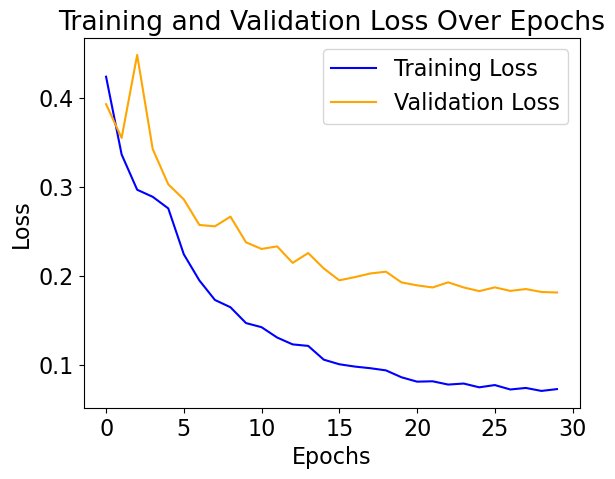

In [16]:
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

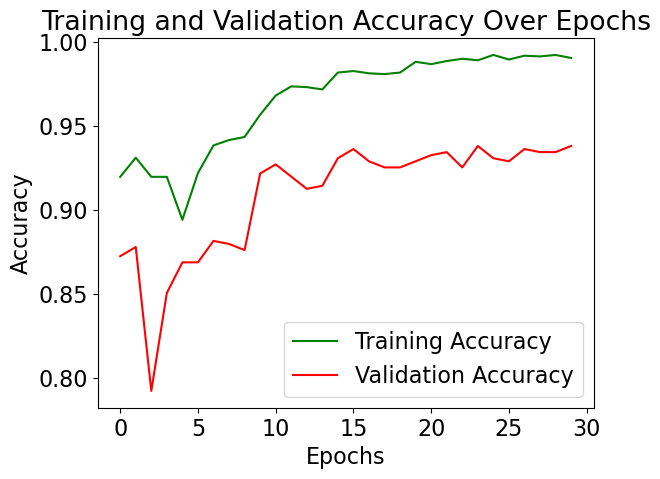

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [18]:
print(y_test.shape)
print(X_test.shape)

scores = ensemble_model.evaluate(X_test,y_test,verbose = 0)
print('\nTesting model on test set:')
print(f'Model Loss: {scores[0]:.3f}, Model Accuracy: {scores[1]:.3f}')

(686, 2)
(686, 128, 128, 3)

Testing model on test set:
Model Loss: 0.177, Model Accuracy: 0.939


In [19]:
predicted_prob = ensemble_model.predict(X_test)

y_pred = np.array([np.argmax(predicted_prob[i, :])
                            for i in range(predicted_prob.shape[0])], dtype = np.int8)

print(y_pred.shape)
print(y_test.shape)
y_test = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


22/22 [==============================] - 2s 72ms/step
(686,)
(686, 2)
Confusion Matrix:
 [[369  18]
 [ 24 275]]


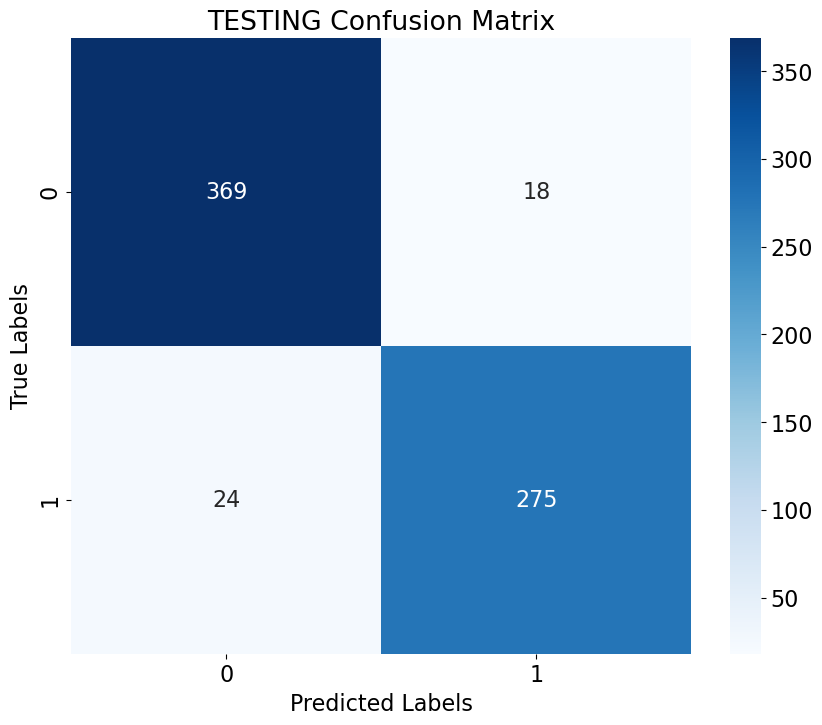

In [20]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('TESTING Confusion Matrix')
plt.show()

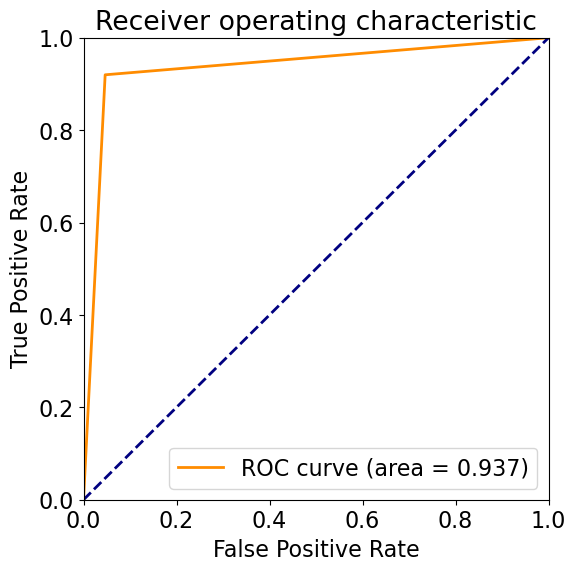

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9426ad36-4e5d-4a61-b6f5-89bb4ca24b94' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>